Packages

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.path as mpath


Functions : Nino 3.4 index

In [22]:
#Function for selecting nino 3.4 region
def extract_nino34_region(ds):
    return ds["tos"].where(
        (ds.latitude < 5) & (ds.latitude > -5) &
        (ds.longitude > 190) & (ds.longitude < 240), drop=True
    )

#Function for creating the index

def compute_nino34_index(hist_ds, future_ds):
    hist_tos = extract_nino34_region(hist_ds) #Extracts region from datasets
    future_tos = extract_nino34_region(future_ds)
    
    climatology = hist_tos.sel(time=slice("1961", "1990")).groupby("time.month").mean() #Creates climatology from selected time period per WMO standard
    
    index_hist = (hist_tos.groupby("time.month") - climatology).mean(dim=["j", "i"]) #removes climatology from datasets and averages along j and i
    index_future = (future_tos.groupby("time.month") - climatology).mean(dim=["j", "i"])
    
    index_hist_smoothed = index_hist.rolling(time=5, center=True).mean().dropna(dim="time", how="all") #smooths it by adding a 5 month running mean and removing NAs
    index_future_smoothed = index_future.rolling(time=5, center=True).mean().dropna(dim="time", how="all")
    
    std_dev = index_hist.sel(time=slice("1961", "1990")).std() #creates standard dev for climatological period
    
    hist_nino34 = index_hist_smoothed / std_dev #removes standard dev
    future_nino34 = index_future_smoothed / std_dev #removes standard dev
    
    return hist_nino34, future_nino34


In [ ]:
Functions: Surface temperature anomalies over Antarctica

In [160]:
import numpy as np

def select_enso_years(tas_anomaly, nino34, threshold=0.5):
    # subect El Niño and La Niña years based on the threshold
    el_nino_years = nino34.time[nino34 > threshold].dt.year.values
    la_nina_years = nino34.time[nino34 < -threshold].dt.year.values
    
    # create list anomalies for El Niño and La Niña years
    el_nino_anomalies = tas_anomaly.sel(time=np.isin(tas_anomaly.time.dt.year, el_nino_years))
    la_nina_anomalies = tas_anomaly.sel(time=np.isin(tas_anomaly.time.dt.year, la_nina_years))
    
    return el_nino_anomalies, la_nina_anomalies, el_nino_years, la_nina_years

def compute_antarctic_anomalies(tas, nino34):
   
    climatology = tas.groupby("time.month").mean(dim="time")
    tas_anomaly = tas.groupby("time.month") - climatology
    
    # select El Niño and La Niña anomalies
    el_nino_anomalies, la_nina_anomalies, el_nino_years, la_nina_years = select_enso_years(tas_anomaly, nino34)
    
    # compite mean anomalies for El Niño and La Niña
    el_nino_mean_anomaly = el_nino_anomalies.mean(dim="time")
    la_nina_mean_anomaly = la_nina_anomalies.mean(dim="time")
    
    # extract the anomalies over Antarctica 
    antarctica_el_nino = el_nino_mean_anomaly.sel(lat=slice(-90, -60))
    antarctica_la_nina = la_nina_mean_anomaly.sel(lat=slice(-90, -60))
    
    return antarctica_el_nino, antarctica_la_nina, el_nino_years, la_nina_years




Analysis 

In [ ]:
hist_ds = xr.open_dataset("tos_Omon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc") #loads in DS as xarray file
                          
future_ds = xr.open_dataset("tos_Omon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc")
                          
hist_nino34, future_nino34 = compute_nino34_index(hist_ds, future_ds) #runs function for nino 3.4 index


hist_tas = xr.open_dataset("tas_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc")["tas"] #surface temp 
future_tas = xr.open_dataset("tas_Amon_ACCESS-ESM1-5_ssp245_r1i1p1f1_gn_201501-210012.nc")["tas"]


hist_antarctica_el_nino, hist_antarctica_la_nina, hist_el_nino_years, hist_la_nina_years = compute_antarctic_anomalies(hist_tas, hist_nino34)
future_antarctica_el_nino, future_antarctica_la_nina, future_el_nino_years, future_la_nina_years = compute_antarctic_anomalies(future_tas, future_nino34)
 
#runs function and outputs the years and spatialy averaged data for each scenario

 Plot - Nino 3.4 line graph

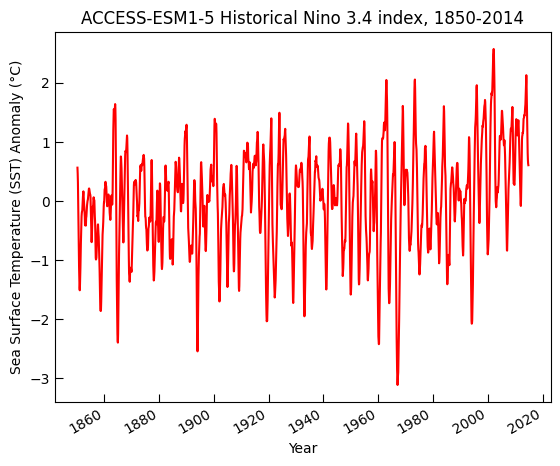

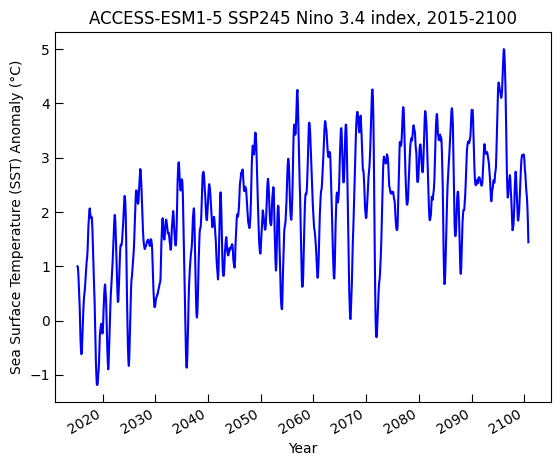

In [68]:
hist_nino34.plot(lw=1.5, color='red')

plt.title("ACCESS-ESM1-5 Historical Nino 3.4 index, 1850-2014")
plt.xlabel("Year")
plt.ylabel("Sea Surface Temperature (SST) Anomaly (°C)") 
plt.tick_params(axis='both', direction='in', length=6)
plt.savefig('ninoindexhist.png', dpi=300, bbox_inches="tight")
plt.show()

future_nino34.plot(lw=1.5, color='blue')

plt.title("ACCESS-ESM1-5 SSP245 Nino 3.4 index, 2015-2100")
plt.xlabel("Year")
plt.ylabel("Sea Surface Temperature (SST) Anomaly (°C)") 
plt.tick_params(axis='both', direction='in', length=6)
plt.savefig('ninoindexssp245.png', dpi=300, bbox_inches="tight")
plt.show()



Plots - Antarctic Anomalies

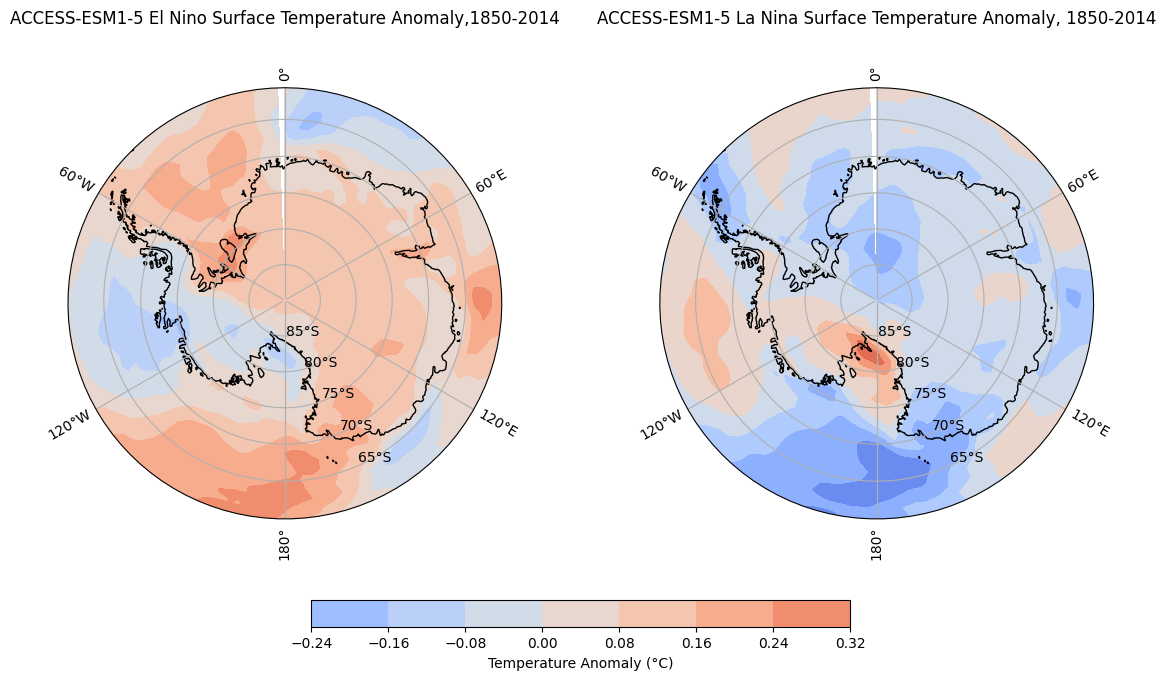

In [158]:
theta = np.linspace(0, 2*np.pi, 100) 
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5]) 
#Makes the plot circular to avoid issues with polar projections, thanks https://fabienmaussion.info/climate_system/projects/04_Getting_started_Antarctica.html!

# Create the figure and axes for two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 7), subplot_kw={"projection": ccrs.SouthPolarStereo()})

#Add vmin and max
histvmin = -0.5

histvmax = 0.5


# Set the format for both plots
for ax in axes:
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  # South Polar region
    ax.set_boundary(map_circle, transform=ax.transAxes)  # Circular boundary
    ax.coastlines() #ads coastlines
    ax.gridlines(draw_labels=True) #ads gridlines


# Plot historical El Niño scenario
ax = axes[0]
im_el_nino = ax.contourf(hist_antarctica_el_nino.lon, hist_antarctica_el_nino.lat, hist_antarctica_el_nino, transform=ccrs.PlateCarree(), vmin=histvmin, vmax=histvmax, cmap='coolwarm')
ax.set_title("ACCESS-ESM1-5 El Nino Surface Temperature Anomaly,1850-2014", pad=30, color='black')


# Plot historical La Niña scenario
ax = axes[1]
im_la_nina = ax.contourf(hist_antarctica_la_nina.lon, hist_antarctica_la_nina.lat, hist_antarctica_la_nina, transform=ccrs.PlateCarree(), vmin=histvmin, vmax=histvmax, cmap='coolwarm')
ax.set_title("ACCESS-ESM1-5 La Nina Surface Temperature Anomaly, 1850-2014", pad=30, color='black')

cbar = fig.colorbar(im_el_nino, ax=axes, orientation='horizontal', fraction=0.05)
cbar.set_label("Temperature Anomaly (°C)")

# Show the plot
plt.savefig("finalhistmap.png", dpi=300)
plt.show()






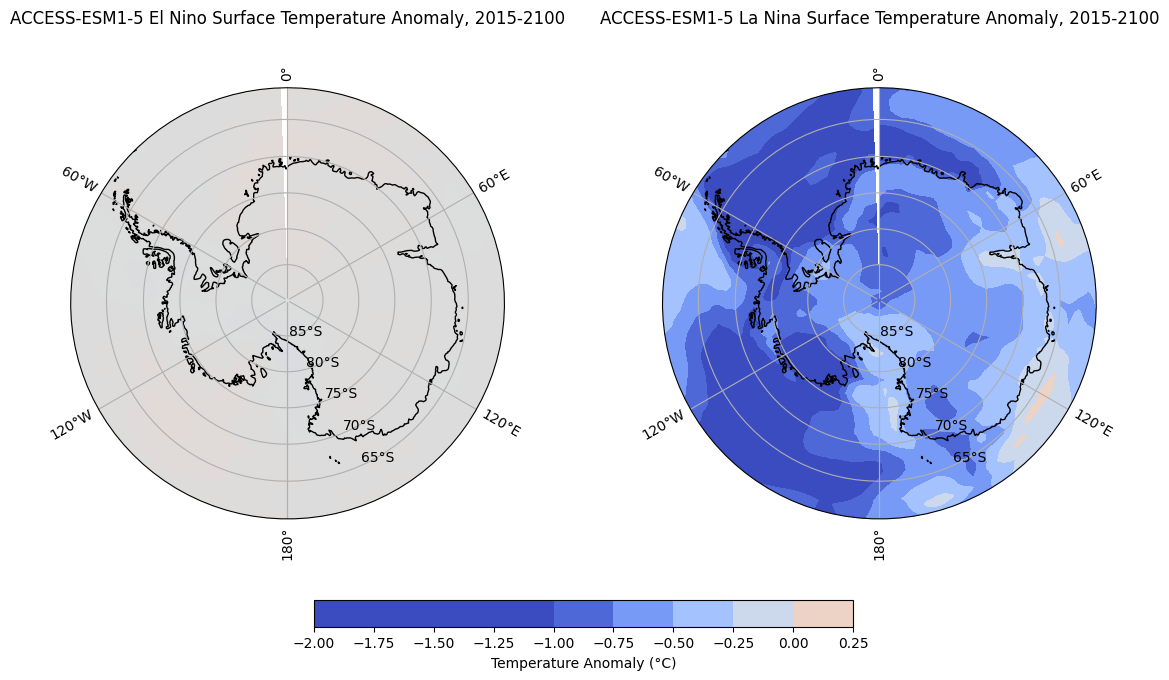

In [182]:
# Create the figure and axes for two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 7), subplot_kw={"projection": ccrs.SouthPolarStereo()})

fmin = -1
fmax = 1

# Set the format for both plots
for ax in axes:
    ax.set_extent([-180, 180, -90, -60], ccrs.PlateCarree())  # South Polar region
    ax.set_boundary(map_circle, transform=ax.transAxes)  # Circular boundary
    ax.coastlines()  # Adds coastlines
    ax.gridlines(draw_labels=True)  # Adds gridlines

# Plot SSP245 El Niño scenario
ax = axes[0]
im_el_ninofuture = ax.contourf(future_antarctica_el_nino.lon, future_antarctica_el_nino.lat, future_antarctica_el_nino, transform=ccrs.PlateCarree(), vmin=fmin, vmax=fmax, cmap='coolwarm')
ax.set_title("ACCESS-ESM1-5 El Nino Surface Temperature Anomaly, 2015-2100", pad=30, color='black')

# Plot SSP245 La Niña scenario
ax = axes[1]
im_la_ninafuture = ax.contourf(future_antarctica_la_nina.lon, future_antarctica_la_nina.lat, future_antarctica_la_nina, vmin=fmin, vmax=fmax, transform=ccrs.PlateCarree(), cmap='coolwarm')
ax.set_title("ACCESS-ESM1-5 La Nina Surface Temperature Anomaly, 2015-2100", pad=30, color='black')

# Add a colorbar 

cbar = fig.colorbar(im_la_ninafuture, ax=axes, orientation='horizontal', fraction=0.05)
cbar.set_label("Temperature Anomaly (°C)")
               
plt.savefig("finalsspmap.png", dpi=300)
plt.show() 
